# 多层神经网络,Sequential和Module

## 一.神经网络解决线性不可分问题

In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [12]:
def plot_decision_boundary(model, x,y):
    x_min, x_max=x[:,0].min()-1, x[:,0].max()+1
    y_min, y_max=x[:,1].min()-1,x[:,1].max()+1
    h=0.01
    #Grnerate a grid of points with distance h between them 生成网络, 间距为h
    xx,yy=np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
    #Predict the function value for the whole grid
    Z=model(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    #plt the contour and training examples
    plt.contour(xx,yy,Z,camp=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:,0],x[:,1],c=y.reshape(-1),s=40,cmap=plt.cm.Spectral)

### 1.构造数据

In [5]:
np.random.seed(1)
m=400 #样本数量
N=int(m/2) #每一类的点的数量
D=2 #维度
x=np.zeros((m,D))
y=np.zeros((m,1),dtype='uint8') # label向量,0表示红色,1表示蓝色
a=4
for j in range(2):
    ix=range(N*j,N*(j+1))
    t=np.linspace(j*3.12,(j+1)*3.12,N)+np.random.randn(N)*0.2
    r=a*np.sin(4*t)+np.random.randn(N)*0.2
    x[ix]=np.c_[r*np.sin(t),r*np.cos(t)]
    y[ix]=j

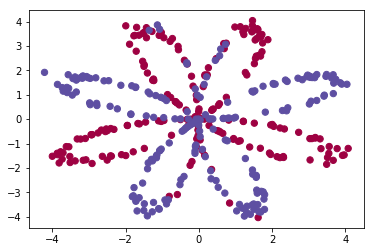

In [7]:
plt.scatter(x[:,0],x[:,1],c=y.reshape(-1),s=40,cmap=plt.cm.Spectral)

### 2.逻辑回归尝试解决上题

In [10]:
x=torch.Tensor(x).float()
y=torch.Tensor(y).float()

w=nn.Parameter(torch.randn(2,1))
b=nn.Parameter(torch.zeros(1))

optimizer=torch.optim.SGD([w,b],lr=1e-1)

def logistic_regression(x):
    return torch.mm(x,w)+b
criterion=nn.BCEWithLogitsLoss()
for e in range(1000):
    out=logistic_regression(Variable(x))
    loss=criterion(out,Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e%200==0:
        print('loss:{:.5f},step:{}'.format(loss,e))

loss:0.77563,step:0
loss:0.67315,step:200
loss:0.67315,step:400
loss:0.67315,step:600
loss:0.67315,step:800


### 2.1画出逻辑回归模型的结果

C:\APP\Anaconda\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\APP\Anaconda\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


Text(0.5,1,'logistic regression')

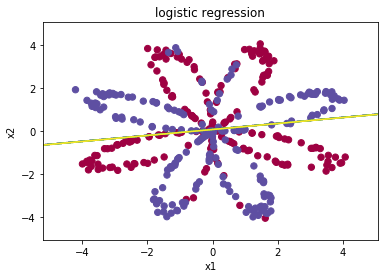

In [13]:
def plot_logistic(x):
    x=Variable(torch.Tensor(x).float())
    out=F.sigmoid(logistic_regression(x))
    out=(out>0.5)*1
    return out.data.numpy()
plot_decision_boundary(lambda x:plot_logistic(x),x.numpy(),y.numpy())
plt.title('logistic regression')

### 3.神经网络尝试解决上题

In [18]:
# 定义两层神经网络的参数
w1=nn.Parameter(torch.randn(2,4)*0.01)
b1=nn.Parameter(torch.zeros(4))
w2=nn.Parameter(torch.randn(4,1)*0.01)
b2=nn.Parameter(torch.zeros(1))

#定义模型
def two_network(x):
    x1=torch.mm(x,w1)+b1
    x1=F.tanh(x1) #使用pytorch自带的tanh激活函数
    x2=torch.mm(x1,w2)+b2
    return x2
optimizer=torch.optim.SGD([w1,w2,b1,b2],lr=1.0)
criterion=nn.BCEWithLogitsLoss()
for e in range(1000):
    out=two_network(Variable(x))
    loss=criterion(out,Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e%200==0:
        print('step:{},loss:{}'.format(e,loss))


C:\APP\Anaconda\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


step:0,loss:0.6930953860282898
step:200,loss:0.339336633682251
step:400,loss:0.30887025594711304
step:600,loss:0.2963810861110687
step:800,loss:0.2892545759677887


### 3.1 画出神经网络的结果

C:\APP\Anaconda\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\APP\Anaconda\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\APP\Anaconda\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


Text(0.5,1,'2 layer network')

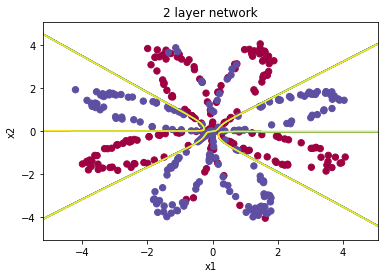

In [20]:
def plt_network(x):
    x=Variable(torch.from_numpy(x).float())
    x1=torch.mm(x,w1)+b1
    x1=F.tanh(x1)
    x2=torch.mm(x1,w2)+b2
    out=F.sigmoid(x2)
    out=(out>0.5)*1
    return out.data.numpy()
plot_decision_boundary(lambda x:plt_network(x),x.numpy(),y.numpy())
plt.title('2 layer network')

## 二. Sequential 和 Module
在现实应用中，一般我们会将模型在本地进行训练，然后保存模型，接着我们会将模型部署到不同的地方进行应用，所以在这节课我们会教大家如何保存 PyTorch 的模型。

对于前面的线性回归模型、 Logistic回归模型和神经网络，我们在构建的时候定义了需要的参数。这对于比较小的模型是可行的，但是对于大的模型，比如100 层的神经网络，这个时候再去手动定义参数就显得非常麻烦，所以 PyTorch 提供了两个模块来帮助我们构建模型，一个是Sequential，一个是 Module。

- Sequential 允许我们构建序列化的模块，
- Module 是一种更加灵活的模型定义方式.

我们下面分别用 Sequential 和 Module 来定义上面的神经网络。

### 1. Sequential构建序列化模块

In [22]:
seq_net=nn.Sequential(
                      nn.Linear(2,4), #pytorch中的线性层, xw+b
                      nn.Tanh(), #激活函数
                      nn.Linear(4,1) #第二层
)

#### 1.1序列模块可以通过索引访问每一层, 这个比Tensorflow要方便

In [24]:
seq_net[0]
#打印出第一层的权重
w0=seq_net[0].weight
print(w0)

Parameter containing:
tensor([[ 0.4720, -0.2466],
        [-0.4728,  0.4256],
        [ 0.1143, -0.3840],
        [ 0.4991,  0.0475]], requires_grad=True)


#### 1.2 通过parameters可以获取模型的参数, 从而放入optim优化器中进行更新

In [25]:
param=seq_net.parameters()

#定义优化器
optimizer=torch.optim.SGD(param,1.)

#### 1.3 训练更新

In [26]:
for e in range(1000):
    out=seq_net(Variable(x))
    loss=criterion(out,Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e %200==0:
        print('step:{},loss:{}'.format(e,loss))

step:0,loss:0.7158772945404053
step:200,loss:0.33342045545578003
step:400,loss:0.3113971948623657
step:600,loss:0.3019006848335266
step:800,loss:0.2958377003669739


#### 1.4展示用sequential生成模型的结果

C:\APP\Anaconda\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\APP\Anaconda\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


Text(0.5,1,'sequential')

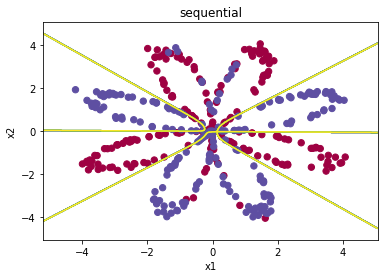

In [30]:
def plot_seq(x):
    out=F.sigmoid(seq_net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out=(out>0.5)*1
    return out
plot_decision_boundary(lambda x:plot_seq(x),x.numpy(),y.numpy())
plt.title('sequential')

## 三. Pytorch保存模型
保存模型在 PyTorch 中有两种方式，一种是将模型结构和参数都保存在一起，一种是只将参数保存下来，下面我们一一介绍。

### 1. 将参数和模型保存在一起:`torch.save()`

In [31]:
torch.save(seq_net,'save_seq_net.pth')

上面就是保存模型的方式，torch.save里面有两个参数，第一个是要保存的模型，第二个参数是保存的路径，读取模型的方式也非常简单

#### 1.1 读取保存的模型

In [32]:
seq_net1=torch.load('save_seq_net.pth')

In [33]:
seq_net1

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [34]:
print(seq_net1[0].weight)

Parameter containing:
tensor([[ 1.7813, -2.6311],
        [ 0.0303,  3.7336],
        [ 3.5228, -4.5270],
        [ 3.1505,  3.7248]], requires_grad=True)


### 2. 只保存模型参数: `torch.save(model.state_dict(), toPath)`

In [35]:
torch.save(seq_net.state_dict(),'save_seq_net_params.pth')

通过上面的方式，我们保存了模型的参数，如果要重新读入模型的参数，首先我们需要重新定义一次模型，接着重新读入参数
#### 2.1 读取模型参数

In [36]:
seq_net2= nn.Sequential(
    nn.Linear(2,4),
    nn.Tanh(),
    nn.Linear(4,1))
seq_net2.load_state_dict(torch.load('save_seq_net_params.pth'))

In [37]:
seq_net2

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [39]:
print(seq_net2[0].weight)

Parameter containing:
tensor([[ 1.7813, -2.6311],
        [ 0.0303,  3.7336],
        [ 3.5228, -4.5270],
        [ 3.1505,  3.7248]], requires_grad=True)


有这两种保存和读取模型的方法，我们推荐使用**第二种-只保留参数**，因为第二种可移植性更强

## 四. 使用Module定义模型并保存

使用module的模板:
    
    class 网络名字(nn.Module):
        def __init__(self, 一些定义的参数):
            super(网络名字, self).__init__()
            self.layer1 = nn.Linear(num_input, num_hidden)
            self.layer2 = nn.Sequential(...)
            ...

            定义需要用的网络层

        def forward(self, x): # 定义前向传播
            x1 = self.layer1(x)
            x2 = self.layer2(x)
            x = x1 + x2
            ...
            return x
注意的是，Module 里面也可以使用 Sequential，同时 Module 非常灵活，具体体现在 forward 中，如何复杂的操作都能直观的在 forward 里面执行

In [41]:
class module_net(nn.Module):
    def __init__(self,num_input,num_hidden,num_output):
        #初始化函数负责定义每一层的函数, 没有参与运算
        super(module_net,self).__init__()
        self.layer1=nn.Linear(num_input,num_hidden)
        self.layer2=nn.Tanh()
        self.layer3=nn.Linear(num_hidden,num_output)
    def forward(self,x):
        #forwar函数负责前向传播, 参与了计算
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

mo_net=module_net(2,4,1)

### 1. 访问模型中的某层可以直接通过名字

In [43]:
# 第一层
l1=mo_net.layer1
print(l1)
#打印出第一层的权重
print(l1.weight)

Linear(in_features=2, out_features=4, bias=True)
Parameter containing:
tensor([[-0.6933, -0.1739],
        [ 0.2197, -0.4830],
        [-0.1359,  0.6068],
        [ 0.0908,  0.4488]], requires_grad=True)


### 2.定义优化器并更新参数

In [46]:
optimizer=torch.optim.SGD(mo_net.parameters(),lr=1.)

for e in range(10000):
    out=mo_net(Variable(x))
    loss=criterion(out,Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e%2000==0:
        print('epoch:{},loss:{}'.format(e,loss.data[0]))

C:\APP\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()


epoch:0,loss:0.2535427510738373
epoch:2000,loss:0.2518487572669983
epoch:4000,loss:0.2505439817905426
epoch:6000,loss:0.249484583735466
epoch:8000,loss:0.2485959678888321


### 3.保存模型

In [47]:
torch.save(mo_net.state_dict(),'module_net.pth')

## 小练习: 五层神经网络构建

In [48]:
class myModule(nn.Module):
    def __init__(self):
        super(myModule,self).__init__()
        self.layer1=nn.Linear(2,10)
        self.layer2=nn.Tanh()
        self.layer3=nn.Linear(10,10)
        self.layer4=nn.Tanh()
        self.layer5=nn.Linear(10,1)
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        return x

In [50]:
M=myModule()
optimizer=torch.optim.SGD(M.parameters(),lr=1.)
for e in range(10000):
    out=M.forward(Variable(x))
    loss=criterion(out,Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e%1000==0:
        print(loss.data)

tensor(0.7068)
tensor(0.1972)
tensor(0.1783)
tensor(0.1581)
tensor(0.1488)
tensor(0.1456)
tensor(0.1413)
tensor(0.1362)
tensor(0.1447)
tensor(0.1271)
